In [90]:
import h5py
import numpy as np
import copy
import math
import time


start_time = time.time()
dimensions = [784, 100, 10]

# w的参数与每一层的个数有关

distribution = [
    {},
    {
        'b': [0, 0], 
        'w': [-math.sqrt(6 / (dimensions[0] + dimensions[1])), math.sqrt(6 / (dimensions[0] + dimensions[1]))]
    },
    {
        'b': [0, 0],
        'w': [-math.sqrt(6 / (dimensions[1] + dimensions[2])), math.sqrt(6 / (dimensions[1] + dimensions[2]))]
    }
]

activations = [passby, tanh, softmax]
differential = {passby: d_passby, softmax: d_softmax, tanh: d_tanh}
onehot = np.eye(dimensions[-1])
epoch_num = 25
learn_rate = 0.5
batch_size = 100


def passby(x):
    '''activation of input layer'''
    return x


def tanh(x):
    '''activation of the hidden layer'''
    return np.tanh(x)


def softmax(x):
    '''activation of output layer'''    
    # In order to avoid the parameters being too large, 
    # subtract the largest one, which is equivalent to each one being negative.
    exp = np.exp(x - x.max()) 
    return exp / exp.sum()


def d_softmax(data):
    '''partial derivative for each element of data under softmax(data)'''
    sm = softmax(data)
    return np.diag(sm) - np.outer(sm, sm)


def d_tanh(data):
    '''partial derivative for each element of data under tanh(data)'''
    return np.diag(1/(np.cosh(data))**2)


def d_passby(data):
    '''partial derivative for each element of given data under passby(data)'''
    return np.identity(len(data))


def init_parameters():
    parameters = []
    for layer in range(len(distribution)):
        layer_parameters = {}
        for key in distribution[layer].keys():
            dist = distribution[layer][key]
            if key == 'b':
                layer_parameters['b'] = np.random.rand(dimensions[layer]) * (dist[1] - dist[0]) + dist[0]
                continue
            if key == 'w':
                layer_parameters['w'] = np.random.rand(dimensions[layer - 1], dimensions[layer]) * (dist[1] - dist[0]) + dist[0]
                continue
        parameters.append(layer_parameters)
    return parameters


def predict(image, parameters):
    layer_input = image
    layer_output = activations[0](layer_input)
    for layer in range(1, len(dimensions)):
        layer_input = np.dot(layer_output, parameters[layer]['w']) + parameters[layer]['b']
        layer_output = activations[layer](layer_input)
    return layer_output


# 计算梯度
def grad_parameters(image, label, parameters):
    layer_input_list = [image]
    layer_output_list = [activations[0](layer_input_list[0])]
    for layer in range(1, len(dimensions)):
        layer_input = np.dot(layer_output_list[layer - 1], parameters[layer]['w']) + parameters[layer]['b']
        layer_output = activations[layer](layer_input)
        layer_input_list.append(layer_input)
        layer_output_list.append(layer_output)

    # back propagation, firstly calculate the partial derivative of the loss for the output
    diff_layer = -2 * (onehot[label] - layer_output_list[-1])
    
    # create gradient result recording updates for every parameters 
    grad_direction = [None] * len(dimensions)
    for layer in range(len(dimensions) - 1, 0, -1):
        # 
        diff_layer = np.dot(differential[activations[layer]](layer_input_list[layer]), diff_layer)
        grad_direction[layer] = {}
        grad_direction[layer]['b'] = diff_layer
        grad_direction[layer]['w'] = np.outer(layer_output_list[layer - 1], diff_layer)
        diff_layer = np.dot(parameters[layer]['w'], diff_layer)
    return grad_direction


def train_batch(current_batch, parameters):
    grad_accu = grad_parameters(data_train[current_batch * batch_size + 0], label_train[current_batch * batch_size + 0],
                                parameters)
    for img_i in range(1, batch_size):
        grad_tmp = grad_parameters(data_train[current_batch * batch_size + img_i],
                                   label_train[current_batch * batch_size + img_i], parameters)
        for layer in range(1, len(grad_accu)):
            for pname in grad_accu[layer].keys():
                grad_accu[layer][pname] += learn_rate * grad_tmp[layer][pname]
    for layer in range(1, len(grad_accu)):
        for pname in grad_accu[layer].keys():
            grad_accu[layer][pname] /= batch_size
    return grad_accu


def combine_parameters(parameters, gradient, learn_rate):
    parameter_tmp = copy.deepcopy(parameters)
    
    for layer in range(1, len(parameter_tmp)):
        for pname in parameter_tmp[layer].keys():
            parameter_tmp[layer][pname] -= learn_rate * gradient[layer][pname]
    return parameter_tmp   


def fit(X_train, y_train, learn_rate=0.5, epoch=25):
    parameters = init_parameters()
    for _ in range(epoch):
        for i in range(train_num // batch_size):
            grad_tmp = train_batch(i, parameters)
            parameters = combine_parameters(parameters, grad_tmp, learn_rate)
    return parameters
    




if __name__ == '__main__':
    with h5py.File('../data/train/images_training.h5','r') as H:
        data_train = np.copy(H['datatrain'])
    with h5py.File('../data/train/labels_training.h5','r') as H:
        label_train = np.copy(H['labeltrain'])
    train_num = data_train.shape[0]
    
    parameters = fit(data_train, label_train, learn_rate, epoch_num)
    
    with h5py.File('../data/test/images_testing.h5', 'r') as H:
        data_test = np.copy(H['datatest'])
    test_num = data_test.shape[0]
    
    output = np.array([predict(data_test[img_i], parameters).argmax() for img_i in range(test_num)])
    
    with h5py.File('predicted_labels.h5','w') as H:
        H.create_dataset('output', data=output)
    
    end_time = time.time()
    print("Total cost {} seconds".format(end_time - start_time))

Total cost 39.70001983642578


--------------------------------------------------------------------------------------------------------------------
the code below is for testing
-------------------------------------------------------------------------------------------------------------

In [91]:
output[:200]

array([1, 0, 9, 1, 6, 6, 0, 0, 8, 0, 2, 4, 9, 9, 8, 0, 9, 0, 0, 3, 3, 3,
       6, 7, 0, 1, 3, 2, 9, 4, 3, 1, 0, 3, 2, 5, 3, 0, 4, 0, 2, 1, 6, 3,
       8, 7, 3, 1, 4, 9, 4, 5, 9, 0, 0, 0, 7, 8, 7, 5, 7, 2, 4, 7, 1, 7,
       0, 0, 6, 8, 5, 0, 3, 7, 7, 7, 4, 7, 3, 4, 1, 0, 8, 9, 7, 2, 4, 8,
       7, 7, 3, 3, 9, 2, 2, 8, 2, 2, 8, 6, 7, 5, 3, 1, 9, 1, 8, 6, 6, 6,
       7, 0, 5, 3, 7, 6, 8, 8, 9, 7, 7, 9, 4, 8, 3, 2, 4, 7, 8, 1, 8, 2,
       1, 5, 3, 8, 9, 5, 5, 8, 1, 4, 5, 6, 9, 8, 8, 7, 5, 3, 7, 8, 6, 8,
       6, 8, 1, 3, 0, 1, 4, 7, 3, 1, 8, 1, 2, 9, 8, 6, 2, 7, 5, 7, 3, 3,
       9, 1, 2, 9, 7, 2, 7, 0, 8, 2, 3, 4, 1, 1, 2, 0, 2, 9, 0, 4, 4, 2,
       8, 4])

In [ ]:
parameters = fit(data_train, label_train)


In [84]:
with h5py.File('../data/test/labels_testing_2000.h5', 'r') as H:
    label_test = np.copy(H['labeltest'][:2000])
# using H['datatest'], H['labeltest'] for test dataset.

# print(data_train.shape,label_train.shape, image_test_with_label.shape)
print(label_test[:200])

[1 0 9 1 6 6 6 6 8 0 0 6 9 9 8 0 9 6 2 3 3 3 6 7 6 1 3 2 9 2 6 1 6 3 2 5 3
 0 4 3 2 1 6 3 8 7 3 1 4 9 6 5 9 0 0 0 7 8 7 5 5 2 4 7 1 7 0 6 6 8 5 0 3 7
 7 7 4 5 3 4 1 0 8 9 7 2 4 8 7 7 3 3 9 2 2 8 4 4 8 6 7 5 3 1 9 1 8 6 6 6 7
 0 5 3 7 6 8 8 9 5 5 9 4 8 3 4 4 7 0 1 8 2 1 5 0 8 5 5 5 8 1 4 5 6 9 8 8 7
 5 3 7 8 6 6 6 8 1 6 0 1 4 7 6 1 8 1 2 9 4 2 2 7 5 7 6 6 9 1 6 9 7 6 7 0 8
 2 3 4 1 1 2 0 2 9 0 4 4 2 8 6]


In [62]:
parameters = fit(data_train, label_train)

In [63]:
print(parameters)

[{}, {'b': array([-0.05198824, -0.03100927, -0.13655414,  0.1129979 , -0.05184229,
        0.19199319, -0.28183665,  0.10363249, -0.0269255 , -0.06063498,
       -0.25811265,  0.14706656, -0.01351919,  0.05939315, -0.06427925,
       -0.10052935, -0.22855366,  0.10459097, -0.42732937,  0.09821171,
       -0.09448514,  0.1482031 ,  0.08853486,  0.35345183, -0.02032906,
       -0.12811559,  0.15016387, -0.00789475,  0.04157849,  0.21695665,
        0.03497093, -0.03998651, -0.03314796,  0.09228344, -0.01715434,
       -0.08719439, -0.0264653 ,  0.08594929, -0.19464754, -0.0017511 ,
        0.01292349, -0.1323566 , -0.19490286,  0.13774678,  0.19036688,
       -0.15164144, -0.12688795,  0.26289995, -0.16729264, -0.04084227,
        0.11667654,  0.11942472, -0.04926765,  0.24609041, -0.19782339,
        0.20847476,  0.02120025,  0.23636152, -0.06977687,  0.06243698,
        0.0423635 ,  0.04788396,  0.06709174, -0.0400331 ,  0.06508318,
       -0.20879065,  0.03590105, -0.10724059, -0.1547

In [70]:
output = np.array([predict(data_test_full[img_i], parameters).argmax() for img_i in range(test_full_num)])

In [72]:
print(test_loss(parameters))
print(test_accuracy(parameters))
print(output)
print(output.shape)

387.91550497649195
0.8665
[1 0 9 ... 2 0 1]
(10000,)


In [73]:
with h5py.File('predicted_labels.h5','w') as H:
    H.create_dataset('output',data=output)

In [27]:
# test b1
h = 0.0001
layer = 1
pname = 'b'
parameters = init_parameters()

for i in range(len(parameters[layer][pname])):
    img_i = np.random.randint(train_num)
    test_parameters = init_parameters()
    derivative = grad_parameters(data_train[img_i], label_train[img_i], test_parameters)[layer][pname]
    value1 = sqr_loss(data_train[img_i], label_train[img_i], test_parameters)
    test_parameters[layer][pname][i] += h
    value2 = sqr_loss(data_train[img_i], label_train[img_i], test_parameters)
    print(derivative[i] - (value2 - value1) / h)

-8.420190178975301e-07
-5.253407351843431e-08
-1.4347755326079951e-07
5.576091151246465e-07
5.387857482490321e-07
-1.1506399201083317e-06
3.785136871783945e-07
-7.66508759849488e-07
8.242797454420525e-07
-4.2649789757168155e-07
-9.496635228157732e-08
-1.7848072397103065e-07
1.0571619020946499e-06
-5.337612158278285e-07
-5.136316596496618e-07
-3.869360288427659e-08
-2.9024961297197116e-06
-2.6145577683173854e-07
-5.981066588944817e-07
7.59019576747691e-09
2.1800225886645097e-08
9.289906363896261e-07
4.6323386078059303e-07
-4.418567066078946e-07
5.878320036567519e-07
1.599242870888029e-06
-3.262352098075058e-07
1.7046307058997748e-07
1.0962012706554336e-06
2.2995188337683603e-08
-1.1570300630916672e-07
-3.5328959067937316e-07
-1.8380996540182104e-06
4.786643500315213e-07
5.003055050627203e-07
-3.4075371303961266e-07
5.187897589714607e-07
-5.987210014331279e-07
3.0223948500451153e-07
-1.4062852321874986e-07
-2.694848937889738e-07
-1.4593226411244165e-06
-6.374320990071292e-07
-1.181152802

In [89]:
# 求平方差函数
def sqr_loss(image, label, parameters):
    y_predict = predict(image, parameters)
    y = onehot[label]
    difference = y - y_predict
    return np.dot(difference, difference)


def train_loss(parameters):
    loss_accu = 0
    for img_i in range(train_num):
        loss_accu += sqr_loss(data_train[img_i], label_train[img_i], parameters)
    return loss_accu/(train_num/30000)


def train_accuracy(parameters):
    correct = [predict(data_train[img_i], parameters).argmax() == label_train[img_i] for img_i in range(train_num)]
#     print("validation accuracy:{}".format(correct.count(True) / len(correct)))
    return correct.count(True) / len(correct)
    

def test_loss(parameters):
    loss_accu = 0
    for img_i in range(test_num):
        loss_accu += sqr_loss(data_test_with_label[img_i], label_test[img_i], parameters)
    return loss_accu/(test_num/2000)


def test_accuracy(parameters):
    correct = [predict(data_test_with_label[img_i], parameters).argmax() == label_test[img_i] for img_i in range(test_num)]
#     print("validation accuracy:{}".format(correct.count(True) / len(correct)))
    return correct.count(True) / len(correct)

In [43]:
from tqdm import tqdm_notebook

current_epoch = 0
train_loss_list = []
train_accu_list = []
test_loss_list = []
test_accu_list = []
parameters = init_parameters()

for epoch in tqdm_notebook(range(epoch_num)):
    for i in range(train_num//batch_size):
        grad_tmp = train_batch(i, parameters)
        parameters = combine_parameters(parameters, grad_tmp, learn_rate)
    current_epoch += 1
    train_loss_list.append(train_loss(parameters))
    train_accu_list.append(train_accuracy(parameters))
    test_loss_list.append(test_loss(parameters))
    test_accu_list.append(test_accuracy(parameters))
        

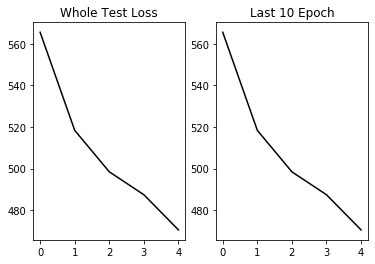

In [44]:
import matplotlib.pyplot as plt

lower = 0

ax1 = plt.subplot(121)
ax1.plot(test_loss_list, color='black', label='validation loss')
ax1.set_title('Whole Test Loss')

ax2 = plt.subplot(122)
ax2.plot(test_loss_list[lower:], color='black', label='validation loss')
ax2.set_title('Last 10 Epoch')
# plt.plot(train_loss_list[lower:], color='red', label='train loss')
plt.show()

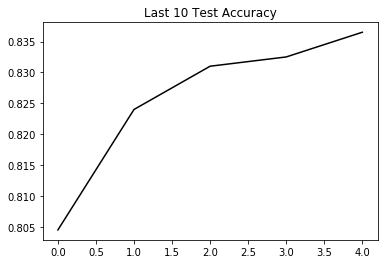

In [46]:
upper = 0
plt.plot(test_accu_list[upper:], color='black', label='validation accuracy')
plt.title('Last 10 Test Accuracy')
# plt.plot(train_accu_list[upper:], color='red', label='train accuracy')
plt.show()